In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Load Data, originally from:
# https://www.kaggle.com/code/danofer/compass-fairml-getting-started/notebook
df = pd.read_csv("./propublica_data_for_fairml.csv", header=0)
df.head()

,Two_yr_Recidivism,Number_of_Priors,score_factor,Age_Above_FourtyFive,Age_Below_TwentyFive,African_American,Asian,Hispanic,Native_American,Other,Female,Misdemeanor
0,0,0,0,1,0,0,0,0,0,1,0,0
1,1,0,0,0,0,1,0,0,0,0,0,0
2,1,4,0,0,1,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,1,0,1
4,1,14,1,0,0,0,0,0,0,0,0,0


In [3]:
# Format the data.
Y = df['score_factor']
X = df.copy()
del X['Two_yr_Recidivism'] # Inappropriate to predict with this - (it's an oracle measure of the outcome).
del X['score_factor']
X = X.astype(float)

feature_names = [x for x in X.columns]
feature_names

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [4]:
# Fit an EBM to the COMPAS data.
from interpret.glassbox import ExplainableBoostingClassifier
ebm1 = ExplainableBoostingClassifier(interactions=0,
                                     outer_bags=1,
                                     inner_bags=1,
                                     early_stopping_rounds=25)
ebm2 = ExplainableBoostingClassifier(interactions=50,
                                     outer_bags=1,
                                     inner_bags=1,
                                     early_stopping_rounds=25)
ebm1.fit(X_train, Y_train)
ebm2.fit(X_train, Y_train)
ebm1_global = ebm1.explain_global(name='EBM1')
ebm2_global = ebm2.explain_global(name='EBM2')

In [5]:
# Purify the EBM.
from gam_purification.models import ebm
gam_results = {
    "uniform": ebm.purify_ebm_uniform(ebm1_global, "compas", should_transpose=False),
    "empirical": ebm.purify_ebm_empirical(ebm1_global, "compas", X_train.values, should_transpose=False),
    "laplace": ebm.purify_ebm_laplace(ebm1_global, "compas", X_train.values,
                                              laplace=1, should_transpose=False)
}
ga2m_results = {
    "uniform": ebm.purify_ebm_uniform(ebm2_global, "compas", should_transpose=False),
    "empirical": ebm.purify_ebm_empirical(ebm2_global, "compas", X_train.values, should_transpose=False),
    "laplace": ebm.purify_ebm_laplace(ebm2_global, "compas", X_train.values,
                                              laplace=1, should_transpose=False)
}

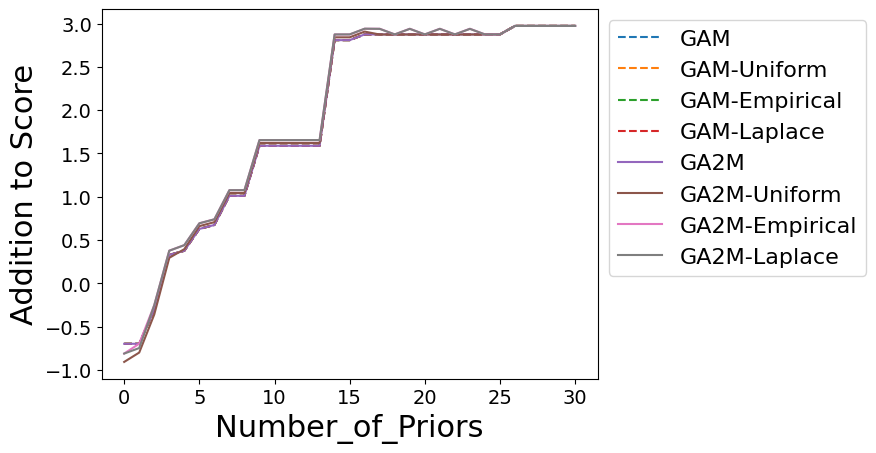

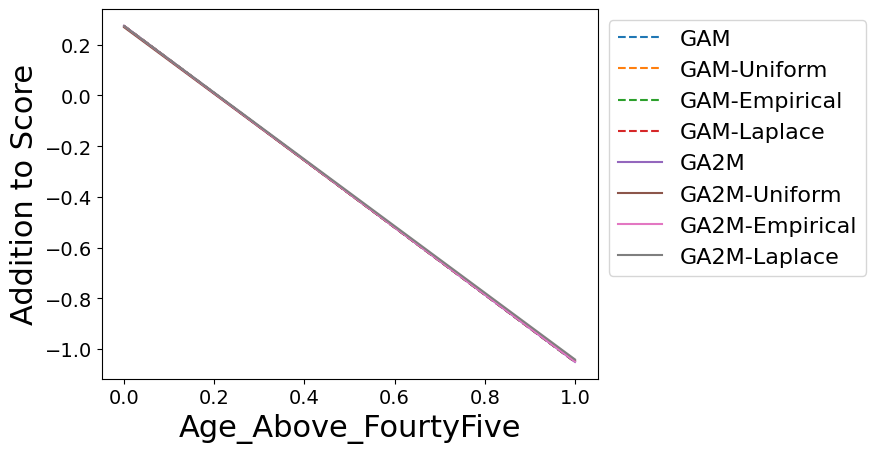

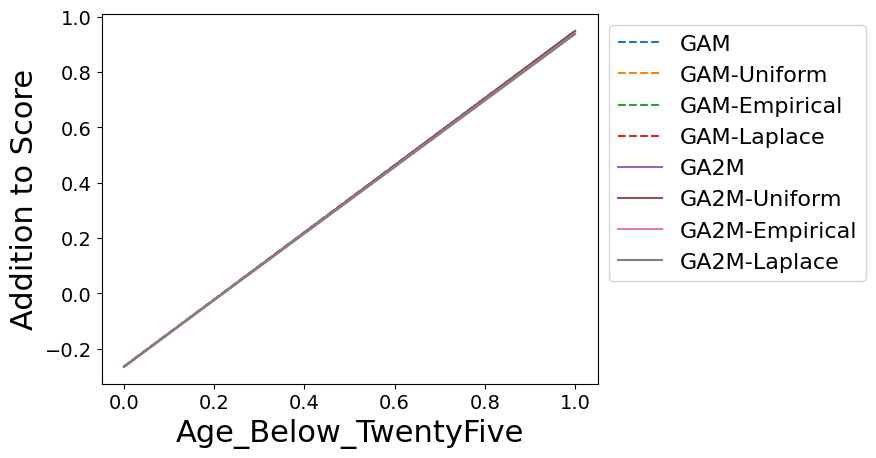

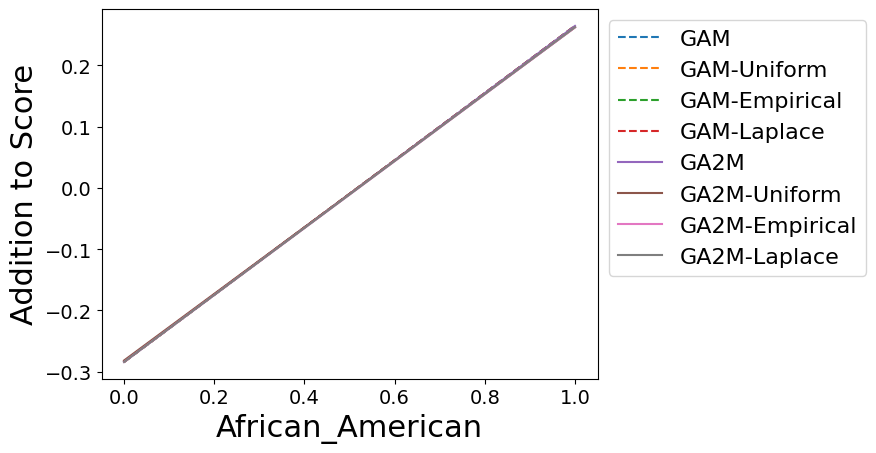

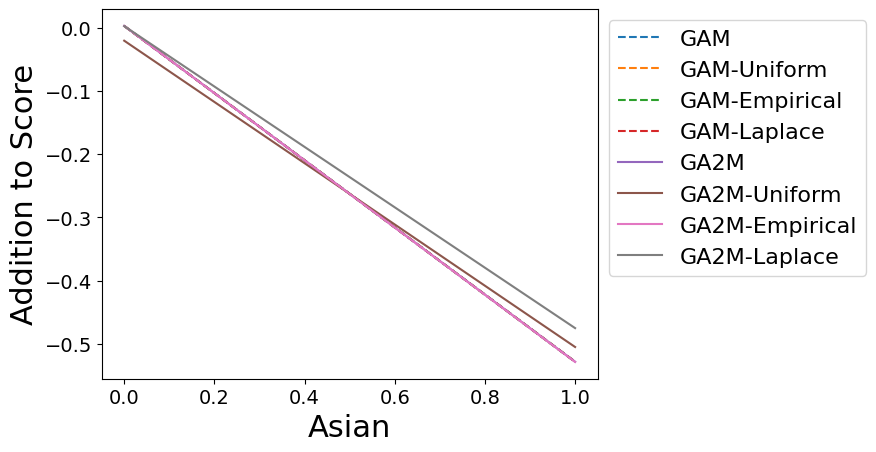

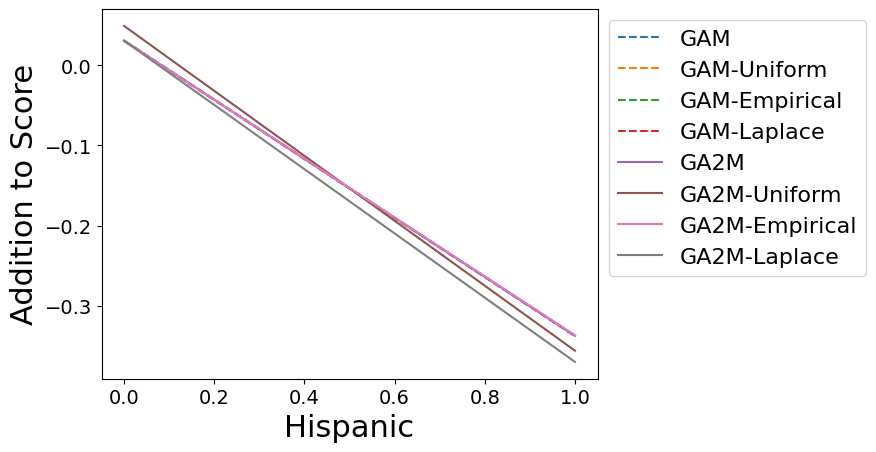

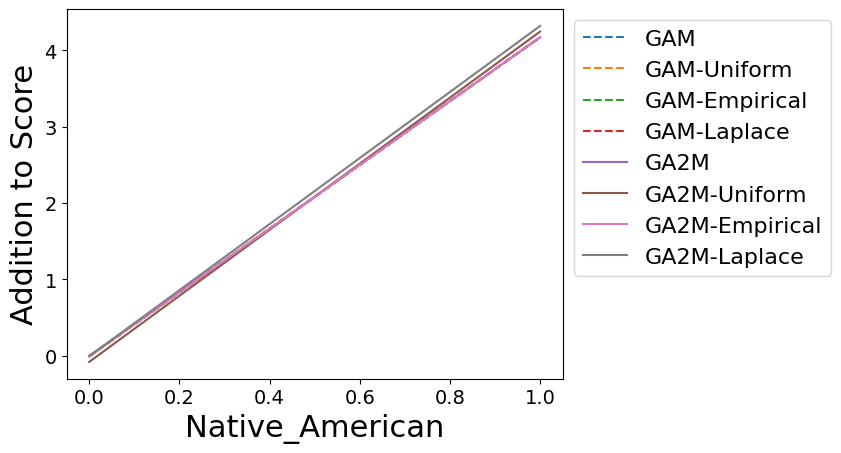

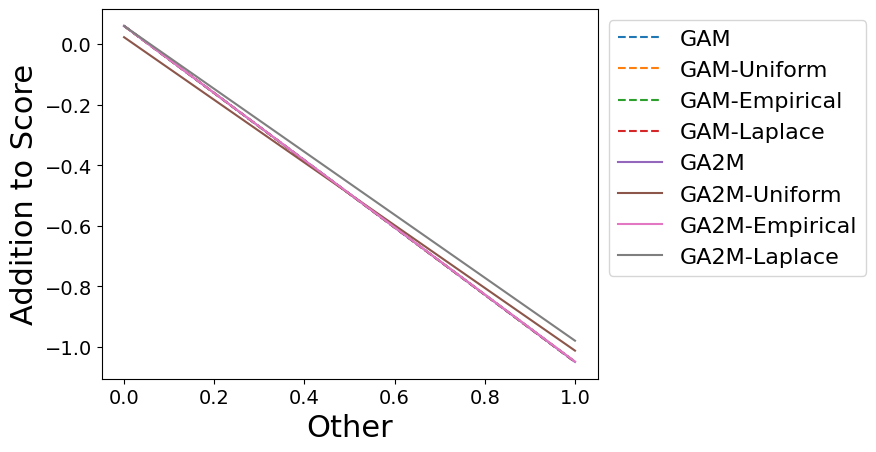

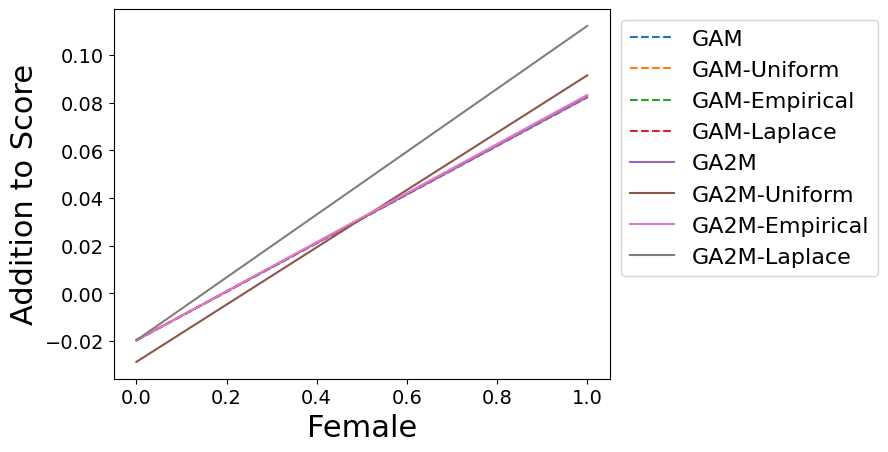

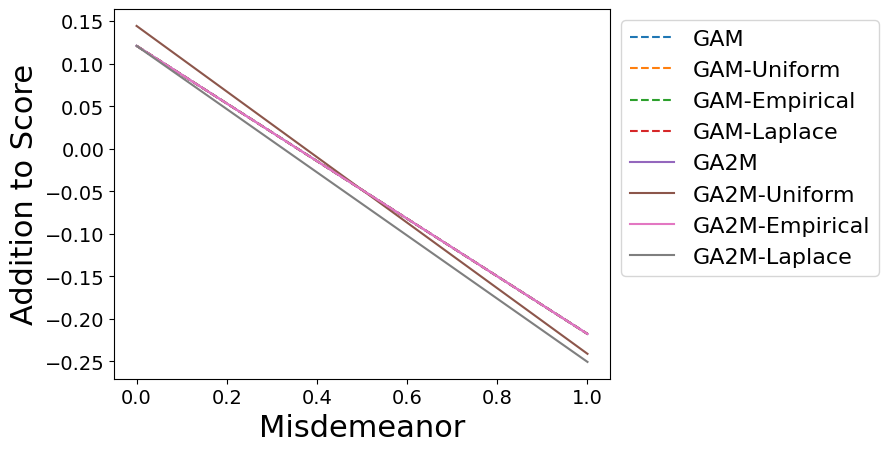

In [6]:
# Plot the main effects learned by the EBM under various purification schemes.
def plot_mains(feat_name):
    idx = feature_names.index(feat_name)
    plt.figure()
    plt.plot(gam_results['uniform']['mains'][idx], linestyle='--', label="GAM")
    plt.plot(gam_results['uniform']['mains_moved'][idx], linestyle='--', label="GAM-Uniform")
    plt.plot(gam_results['empirical']['mains_moved'][idx], linestyle='--', label="GAM-Empirical")
    plt.plot(gam_results['laplace']['mains_moved'][idx], linestyle='--', label="GAM-Laplace")
    
    plt.plot(ga2m_results['uniform']['mains'][idx], label="GA2M")
    plt.plot(ga2m_results['uniform']['mains_moved'][idx], label="GA2M-Uniform")
    plt.plot(ga2m_results['empirical']['mains_moved'][idx], label="GA2M-Empirical")
    plt.plot(ga2m_results['laplace']['mains_moved'][idx], label="GA2M-Laplace")
    plt.xlabel(feat_name, fontsize=22)
    plt.ylabel("Addition to Score", fontsize=22)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    lgd = plt.legend(fontsize=16, bbox_to_anchor=(1.0, 1.0))

for feat_name in feature_names:
    plot_mains(feat_name)

In [7]:
# Fit an XGB model to the COMPAS data.

# TODO: XGB purification is not currently supported.

import xgboost as xgb
from gam_purification.models import xgb as xgb_utils

X_train_train, X_val, y_train_train, y_val = train_test_split(X_train, Y_train, test_size=0.2)

xgb1 = xgb.XGBClassifier(max_depth=1, learning_rate=0.1, n_estimators=1500)
xgb1.fit(X_train_train, y_train_train, eval_set=[(X_val, y_val)],
        verbose=False, eval_metric='rmse', early_stopping_rounds=50)

xgb2 = xgb.XGBClassifier(max_depth=2, learning_rate=0.1, n_estimators=1500)
xgb2.fit(X_train_train, y_train_train, eval_set=[(X_val, y_val)],
        verbose=False, eval_metric='rmse', early_stopping_rounds=50)

raw_xgb1_dump = xgb1.get_booster().get_dump()
raw_xgb2_dump = xgb2.get_booster().get_dump()

def get_xgb_pairs(raw_xgb_dump):
    xgb_pairs_raw = []
    for tree in raw_xgb_dump:
        tree1_splits, tree2_splits = xgb_utils.parse_xgb_tree(tree, [])
        xgb_pairs_raw.append(tree1_splits)
        xgb_pairs_raw.append(tree2_splits)
    return xgb_pairs_raw

xgb1_pairs_raw = get_xgb_pairs(raw_xgb1_dump)
xgb2_pairs_raw = get_xgb_pairs(raw_xgb2_dump)

xgb1_mains, xgb1_pairs, n_pairwise, n_marginal = xgb_utils.get_mains_and_pairs(
    xgb1_pairs_raw, ebm2_global, ebm2_global.feature_names)
xgb2_mains, xgb2_pairs, n_pairwise, n_marginal = xgb_utils.get_mains_and_pairs(
    xgb2_pairs_raw, ebm2_global, ebm2_global.feature_names)

dataset_name = "compas"
xgb_results = {
    "uniform": xgb_utils.purify_xgb_uniform(xgb2_mains, xgb2_pairs, ebm2_global, dataset_name),
    "empirical": xgb_utils.purify_xgb_empirical(xgb2_mains, xgb2_pairs, ebm2_global, dataset_name,
                                                X_train.values),
    "laplace": xgb_utils.purify_xgb_laplace(xgb2_mains, xgb2_pairs, ebm2_global, dataset_name,
                                                   X_train.values, laplace=1)
}

/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [ ]:
# Plot the effects learned under different distributions of purification.
def diff(results):
    return results[1] - results[0]

fig = plt.figure(figsize=(12, 10))
n_parts = 12
w = 1. / n_parts
for idx, feat_name in enumerate(feature_names):
    if idx == 0:
        plt.bar([(n_parts*idx+1)/n_parts], diff(gam_results['uniform']['mains'][idx]), width=w, label="GAM", color='gray')
        plt.bar([(n_parts*idx+2)/n_parts], diff(ga2m_results['uniform']['mains'][idx]), width=w, label="GA2M", color='lightgray')
        plt.bar([(n_parts*idx+3)/n_parts], diff(ga2m_results['uniform']['mains_moved'][idx]), width=w, label="GA2M-Uniform", color='blue')
        plt.bar([(n_parts*idx+4)/n_parts], diff(ga2m_results['empirical']['mains_moved'][idx]), width=w, label="GA2M-Empirical", color='green')
        plt.bar([(n_parts*idx+5)/n_parts], diff(ga2m_results['laplace']['mains_moved'][idx]), width=w, label="GA2M-Laplace", color='red')
    else:
        plt.bar([(n_parts*idx+1)/n_parts], diff(ga2m_results['uniform']['mains'][idx]), width=w, color='gray')
        plt.bar([(n_parts*idx+2)/n_parts], diff(ga2m_results['uniform']['mains'][idx]), width=w, color='lightgray')
        plt.bar([(n_parts*idx+3)/n_parts], diff(ga2m_results['uniform']['mains_moved'][idx]), width=w, color='blue')
        plt.bar([(n_parts*idx+4)/n_parts], diff(ga2m_results['empirical']['mains_moved'][idx]), width=w, color='green')
        plt.bar([(n_parts*idx+5)/n_parts], diff(ga2m_results['laplace']['mains_moved'][idx]), width=w, color='red')
    if idx == 0:
        plt.bar([(n_parts*idx+6)/n_parts], diff(xgb1_mains.get(feature_names[idx], [0.0, 0.0])), width=w, hatch='/', label="XGB", color='gray')
        plt.bar([(n_parts*idx+7)/n_parts], diff(xgb2_mains.get(feature_names[idx], [0.0, 0.0])), width=w, hatch='/', label="XGB-2", color='lightgray')
        plt.bar([(n_parts*idx+8)/n_parts], diff(xgb_results['uniform']['mains_moved'].get(idx, [0.0, 0.0])), width=w, hatch='/', label="XGB2-Uniform", color='blue')
        plt.bar([(n_parts*idx+9)/n_parts], diff(xgb_results['empirical']['mains_moved'].get(idx, [0.0, 0.0])), width=w, hatch='/', label="XGB2-Empirical", color='green')
        plt.bar([(n_parts*idx+10)/n_parts], diff(xgb_results['laplace']['mains_moved'].get(idx, [0.0, 0.0])), width=w, hatch='/', label="XGB2-Laplace", color='red')
    else:
        plt.bar([(n_parts*idx+6)/n_parts], diff(xgb1_mains.get(feature_names[idx], [0.0, 0.0])), width=w, hatch='/', color='gray')
        plt.bar([(n_parts*idx+7)/n_parts], diff(xgb2_mains.get(feature_names[idx], [0.0, 0.0])), width=w, hatch='/', color='lightgray')
        plt.bar([(n_parts*idx+8)/n_parts], diff(xgb_results['uniform']['mains_moved'].get(idx, [0.0, 0.0])), width=w, hatch='/', color='blue')
        plt.bar([(n_parts*idx+9)/n_parts], diff(xgb_results['empirical']['mains_moved'].get(idx, [0.0, 0.0])), width=w, hatch='/', color='green')
        plt.bar([(n_parts*idx+10)/n_parts], diff(xgb_results['laplace']['mains_moved'].get(idx, [0.0, 0.0])), width=w, hatch='/', color='red')
    
plt.ylim([-3, 4.0])
lgd = plt.legend(bbox_to_anchor=(1., 1.0), fontsize=18)
plt.xticks([0.4 + x for x in range(len(feature_names))], feature_names, rotation=70, fontsize=20)
plt.ylabel("Addition to Score", fontsize=26)
plt.yticks(fontsize=18)
plt.show()